<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Performing_PCA_with_an_Undercomplete_Linear_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'autoencoders'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be undercomplete. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).

In [5]:
# Build 3D dataset
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

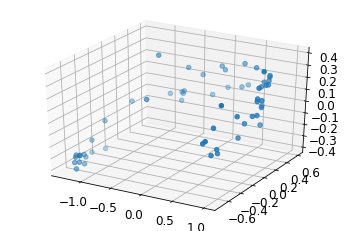

In [6]:
# Plot 3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2])

plt.show()

The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D:

Inputs: size = 3: x1, x2, x3

Encoder: Dense layer with 2 nodes

Decoder: Dense layer with 3 nodes

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# Number of inputs and number of outputs are the same
n_inputs = 3
n_outputs = 3

In [9]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[n_inputs])])
decoder = keras.models.Sequential([keras.layers.Dense(n_outputs, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1.e-5))

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3173
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3173
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3173
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3173
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.3173
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3173
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

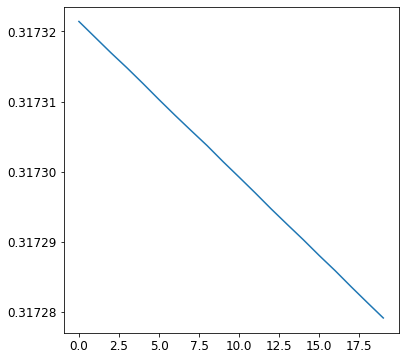

In [11]:
# Plot LOSS vs epochs
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.show()

In [12]:
codings = encoder.predict(X_train)
print( codings.shape )
codings[:5, :]

(60, 2)


array([[-0.2424683 ,  0.00431337],
       [ 0.08288547,  0.0896422 ],
       [-0.37367022,  0.12309518],
       [-0.5006212 ,  0.12196257],
       [ 0.28895903, -0.10140171]], dtype=float32)

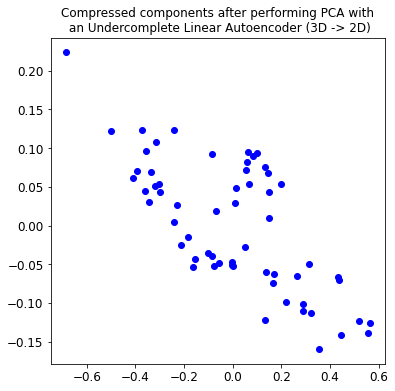

In [14]:
# Plot the compressed components / important components
plt.figure(figsize=(6,6))
plt.plot(codings[:, 0], codings[:, 1], 'bo')
plt.title('Compressed components after performing PCA with\n an Undercomplete Linear Autoencoder (3D -> 2D)')
plt.show()